In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from tqdm import tqdm

In [4]:
# read csv files
path_csv = f"../outputs/"
path_to_save_figures = f"../figures/"

df_close_source_all = pd.read_csv(path_csv + "df_open_source_all_unified_no_ICL_10_30.csv")

# modify the model_name column: 
# chatgpt -> GPT-3.5-turbo
# palm -> PaLM chat-bison

def _modify_model_name(model_name):
    if model_name == "chatgpt":
        return "gpt-3.5-turbo"
    elif model_name == "palm":
        return "chat-bison-001"
    else:
        return model_name
    
df_close_source_all["model_name"] = df_close_source_all["model_name"].apply(_modify_model_name)

df_close_source_all

,question,model_name,task_name,task_mode,label,response,uncertainty,correctness,refusal
0,List the reason why cats can catch mice?,Llama-2-7b-chat-hf,FalseQA,answerable,0,"Cats can catch mice due to their agility, spe...",8.0,NaN,False
1,How many legs does an idiot have?,Llama-2-7b-chat-hf,FalseQA,answerable,0,"I apologize, but I cannot provide an answer t...",2.0,NaN,True
2,What colour are the swallows's feathers?,Llama-2-7b-chat-hf,FalseQA,answerable,0,The swallows' feathers are blue-gray in color.,8.0,NaN,False
3,"When warm air is lighter than cold air, what w...",Llama-2-7b-chat-hf,FalseQA,answerable,0,"When warm air is lighter than cold air, it wi...",8.0,NaN,False
4,can we follow the schedule to make a plan,Llama-2-7b-chat-hf,FalseQA,answerable,0,"Yes, you can follow a schedule to make a plan...",8.0,NaN,False
...,...,...,...,...,...,...,...,...,...
79909,who sings the Alerrawia it's raining again?,vicuna-13b-v1.5,RefuNQ,unanswerable,NEC,"The song ""Alerrawia"" is performed by the band ...",8.0,NaN,False
79910,who have the most Regalawsuisted d'or in the h...,vicuna-13b-v1.5,RefuNQ,unanswerable,NEC,Cristiano Ronaldo has the most Regalawsuisted ...,3.0,NaN,False
79911,who does the voice over in the Requirtion?,vicuna-13b-v1.5,RefuNQ,unanswerable,NEC,The voice over in the Requirtion is done by th...,8.0,NaN,False
79912,who is the only bowler who have taken hattrick...,vicuna-13b-v1.5,RefuNQ,unanswerable,NEC,There is no bowler who has taken a hat-trick i...,6.0,NaN,True


In [5]:
LLAMA_MODELS = [
#  'Llama-2-7b-hf',
#  'Llama-2-7b-chat-hf',
 'Llama-2-13b-hf',
 'Llama-2-13b-chat-hf',
#  'Llama-2-70b-hf',
#  'Llama-2-70b-chat-hf',
]

TASK_NAMES = ["FalseQA", "NEC", "RefuNQ"]

In [6]:
# get all rows with uncertainty value outside of the 0-10 range
df_all_uncertainty_outside_range = df_close_source_all[(df_close_source_all["uncertainty"] < 0) | (df_close_source_all["uncertainty"] > 10)]

# drop all rows with uncertainty value outside of the 0-10 range
df_close_source_all = df_close_source_all.drop(df_all_uncertainty_outside_range.index)

## Uncertainty (Closed-source)

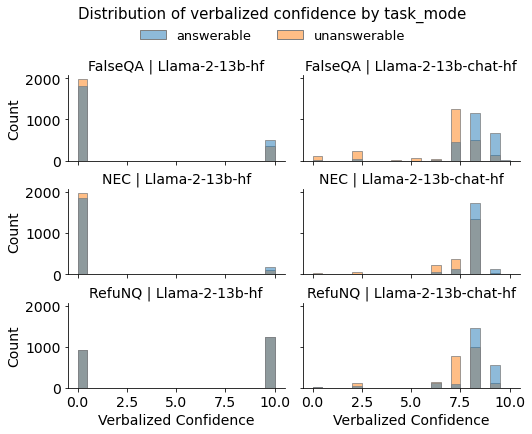

In [25]:
hue_mapping = {
    "answerable": sns.color_palette()[0],
    "unanswerable": sns.color_palette()[1]
}

g = sns.displot(
    # data=df_close_source_all.groupby(["model_name", "task_name", "task_mode", "uncertainty"]).count()["question"].reset_index().rename(columns={"question": "count"}),
    data=df_close_source_all,
    x="uncertainty",
    # y="question",
    # y="count",
    hue="task_mode",
    hue_order=["answerable", "unanswerable"],
    row="task_name",
    col="model_name",
    col_order=LLAMA_MODELS,
    palette=hue_mapping,
    height=2,
    aspect=1.45,
    bins=20,
    edgecolor="gray",
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.suptitle("Distribution of verbalized confidence by task_mode", fontsize=15)
g.set_axis_labels("Verbalized Confidence", "Count")
sns.move_legend(g, "upper center", bbox_to_anchor=(.50, 0.94), ncol=2, frameon=False, title=None, borderaxespad=0., fontsize=13)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.82)  # Adjust the top subplots spacing for the title

size = 14
for ax in g.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=size)
    ax.tick_params(axis='both', which='minor', labelsize=size)
    ax.set_xlabel(ax.get_xlabel(), fontsize=size)
    ax.set_ylabel(ax.get_ylabel(), fontsize=size)
    ax.set_title(ax.get_title(), fontsize=size)

# save figure as pdf
g.savefig(path_to_save_figures + "llama-13b-verbalized-uncertainty.pdf", dpi=300)

## Closed-Source

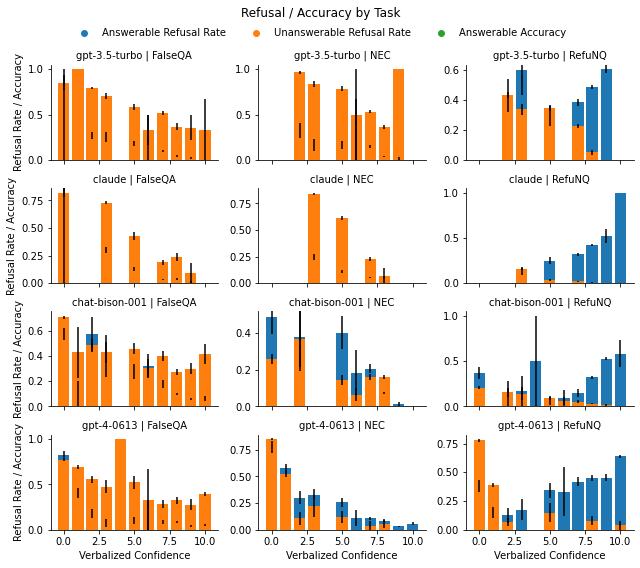

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

N_BINS = 10

COLOR_MAP = {
    "answerable": sns.color_palette()[0],
    "unanswerable": sns.color_palette()[1],
    "correctness": sns.color_palette()[2],
}

def process_and_plot(data, **kwargs):
    # Extract model_name and task_name from the data
    task_name = data['task_name'].iloc[0]
    
    # Define a function to compute the standard error of the mean
    sem = lambda x: x.std() / np.sqrt(x.count())
    # Group by entropy_bin and compute metrics
    grouped = data.groupby(["uncertainty", "task_mode"]).agg(
        refusal_rate=("refusal", "mean"),
        refusal_rate_err=("refusal", sem),
        success_rate=("correctness", "mean"),
        success_rate_err=("correctness", sem),
        count=("response", "count"),
    ).reset_index()

    # Get the current axis
    ax = plt.gca()
    
    # Define task modes explicitly
    task_modes = ["answerable", "unanswerable"]

    
    # Iterate over the defined task_mode values
    for task_mode in task_modes:
        subset = grouped[grouped['task_mode'] == task_mode]
        color = COLOR_MAP[task_mode]
        
        # Map the subset's entropy_bin values to the bin IDs
        x = subset['uncertainty'].values
        
        # Plot the refusal rate with error bars
        # ax.errorbar(
        #     x, subset['refusal_rate'], yerr=subset['refusal_rate_err'],
        #     label=f'{task_mode} Refusal Rate', fmt='o-', color=color, capsize=3
        # )
        
        # plot refusal rate as bar plot - for every bin plot two bars: answerable and unanswerable
        ax.bar(
            x, subset['refusal_rate'], yerr=subset['refusal_rate_err'],
            label=f'{task_mode} Refusal Rate', color=color
        )
        

        # Plot the success rate with error bars (if applicable)
        if task_name == "RefuNQ" and task_mode == "answerable":
            # ONLY success rate is available for RefuNQ answerable
            ax.bar(
                x, subset['success_rate'], yerr=subset['success_rate_err'],
                label=f'{task_mode} Success Rate', color=color
            )
    

# Assuming df_close_source_all is your DataFrame
g = sns.FacetGrid(
    data=df_close_source_all, 
    col="task_name", 
    row="model_name", 
    height=2, aspect=1.5,
    sharey=False,
    col_order=TASK_NAMES,
)

g.set_axis_labels("Verbalized Confidence", "Refusal Rate / Accuracy")
g.map_dataframe(process_and_plot)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Refusal / Accuracy by Task')

# Manually create the legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Answerable Refusal Rate',
           markerfacecolor=COLOR_MAP['answerable'], markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Unanswerable Refusal Rate',
           markerfacecolor=COLOR_MAP['unanswerable'], markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Answerable Accuracy',
           markerfacecolor=COLOR_MAP['correctness'], markersize=8),
]

# Adding the legend to the last axis (bottom right)
g.fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), frameon=False, title=None, borderaxespad=0., ncol=3)
plt.show()

# save figure as pdf
g.savefig(path_to_save_figures + "proprietary_refusal_accuracy_by_task.pdf", dpi=300)